# Martingale

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Martingale import Martingale
from util.Save_result_return import save_to_csv





## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = Martingale

In [6]:
account_size = 10000

# Backtest each time frame

## TF D1

In [7]:
Backtest_D1 = Backtest(XAUUSD['D1'], strategy, cash=account_size, margin=1/100,  commission=0.0002 )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.583581
Equity Final [$]                   8097.64089
Equity Peak [$]                  10034.984028
Return [%]                         -19.023591
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -1.048894
Volatility (Ann.) [%]                 1.74261
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -20.911828
Avg. Drawdown [%]                   -4.277711
Max. Drawdown Duration     5853 days 00:00:00
Avg. Drawdown Duration     1177 days 00:00:00
# Trades                                 1782
Win Rate [%]                         47.08193
Best Trade [%]                       2.125038
Worst Trade [%]                     -2.117634
Avg. Trade [%]                    

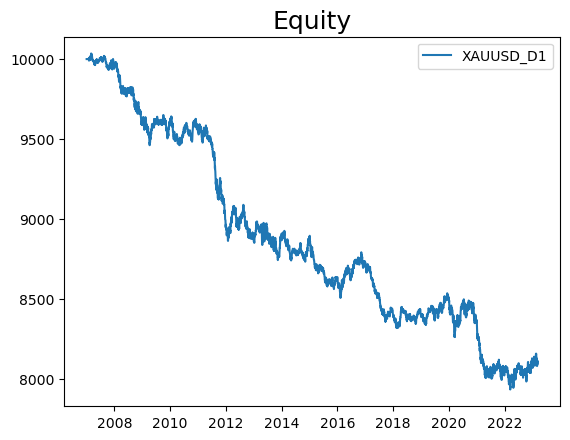

In [8]:
plot_equity_trades(result_D1['_equity_curve'],'XAUUSD_D1' , account_size)

### Save output

In [9]:
save_to_csv(result_D1, '../../out/Technical_Strategy/Martingale//Backtest/result_D1.csv')  

## TF H4

In [10]:
Backtest_H4 = Backtest(XAUUSD['H4'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   99.919156
Equity Final [$]                  4840.099453
Equity Peak [$]                  10063.468009
Return [%]                         -51.599005
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -3.561136
Volatility (Ann.) [%]                2.023719
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -52.494106
Avg. Drawdown [%]                   -2.810722
Max. Drawdown Duration     5855 days 08:00:00
Avg. Drawdown Duration      310 days 15:00:00
# Trades                                 8481
Win Rate [%]                        47.553355
Best Trade [%]                       1.569698
Worst Trade [%]                     -1.030331
Avg. Trade [%]                    

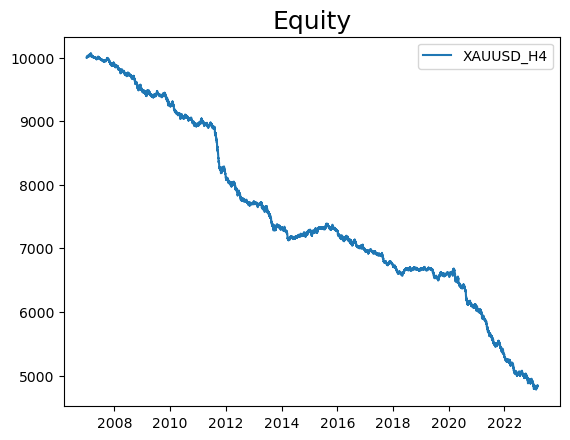

In [11]:
plot_equity_trades(result_H4['_equity_curve'], 'XAUUSD_H4' , account_size)

### Save output

In [12]:
save_to_csv(result_H4, '../../out/Technical_Strategy/Martingale//Backtest/result_H4.csv')  

## TF H1

In [13]:
Backtest_H1 = Backtest(XAUUSD['H1'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   94.244237
Equity Final [$]                    15.941021
Equity Peak [$]                  10002.110093
Return [%]                          -99.84059
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -27.52194
Volatility (Ann.) [%]               30.425634
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.840623
Avg. Drawdown [%]                  -49.922167
Max. Drawdown Duration     5911 days 17:00:00
Avg. Drawdown Duration     2955 days 22:00:00
# Trades                                29637
Win Rate [%]                        48.972568
Best Trade [%]                       1.349615
Worst Trade [%]                     -1.342397
Avg. Trade [%]                    

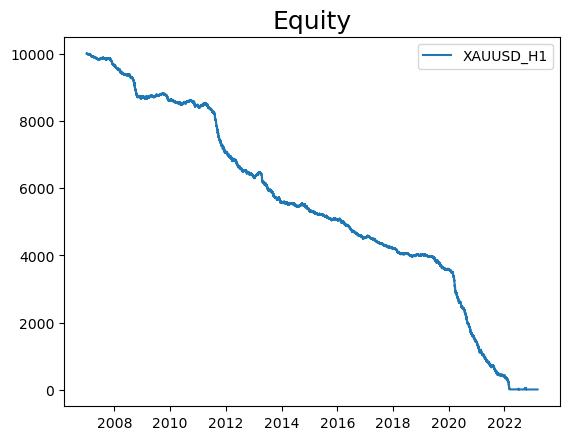

In [14]:
plot_equity_trades(result_H1['_equity_curve'], 'XAUUSD_H1', account_size)

### Save output

In [15]:
save_to_csv(result_H1, '../../out/Technical_Strategy/Martingale/Backtest/result_H1.csv')  

## TF M30 

In [16]:
Backtest_M30 = Backtest(XAUUSD['M30'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                    61.94625
Equity Final [$]                    10.188882
Equity Peak [$]                   10008.54896
Return [%]                         -99.898111
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -29.124381
Volatility (Ann.) [%]               19.665794
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.898198
Avg. Drawdown [%]                   -8.370369
Max. Drawdown Duration     5882 days 04:30:00
Avg. Drawdown Duration      492 days 16:20:00
# Trades                                39165
Win Rate [%]                        49.812332
Best Trade [%]                       0.662466
Worst Trade [%]                     -1.018565
Avg. Trade [%]                    

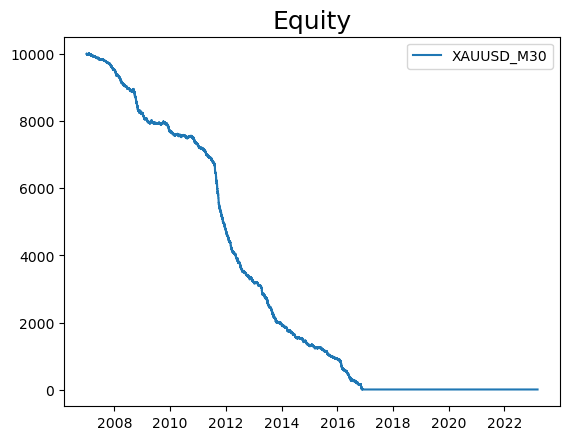

In [17]:
plot_equity_trades(result_M30['_equity_curve'], 'XAUUSD_M30', account_size)

### Save output

In [18]:
save_to_csv(result_M30, '../../out/Technical_Strategy/Martingale/Backtest/result_M30.csv')  